# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Data Download

In [2]:
data_dir = '~/.pytorch/digit_MNIST_data/'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

# Preparation of Train/Test sets and Data Loader

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

BATCH_SIZE = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Definition of Variational Autoencoder

In [4]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, latent_dims, fc2_input_dim):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, fc2_input_dim)
        self.linear2 = nn.Linear(fc2_input_dim, latent_dims)  # For mean, mu
        self.linear3 = nn.Linear(fc2_input_dim, latent_dims)  # For covariance, sigma
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # Came from Kullback-Leibler Divergence
        
        return z

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 3*3*32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, fc2_input_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, fc2_input_dim)
        self.decoder = Decoder(latent_dims, fc2_input_dim)
        
    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

# Initialization of Loss Functions and Optimizer

In [7]:
# Define an optimizer (both for the encoder and the decoder!)
lr = 0.001

# Set the random seed for reproducible results
torch.manual_seed(0)

# Initialize the two networks
d = 4

vae = VariationalAutoencoder(latent_dims=d, fc2_input_dim=128)

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

# Train and Evaluation of Model

In [8]:
# Training function
def train_epoch(vae, device, dataloader, optimizer, verbose=False):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl  # For reconstruction error, MSE is used (BCE is also used)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if verbose == True:
            print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)

In [9]:
# Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl  # For reconstruction error, MSE is used (BCE is also used)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [10]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets==i)[0][0] for i in range(n)}
    
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if i == n//2:    # To have the title at the center
            ax.set_title('Original images')
            
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if i == n//2:   # To have the title at the center
            ax.set_title('Reconstructed images')
    plt.show()


 EPOCH 1/50 	 train loss 141.8623145345052 	 val loss 76.65530649414063


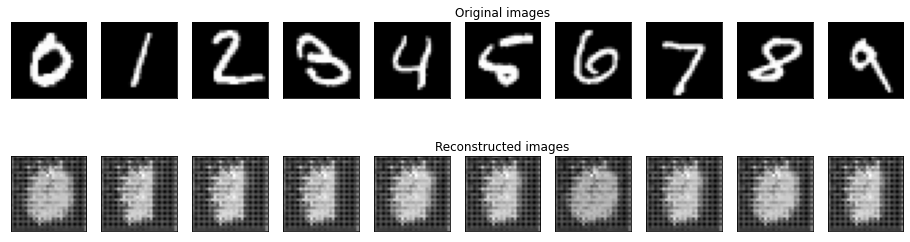


 EPOCH 5/50 	 train loss 37.32836283365885 	 val loss 36.51549506225586


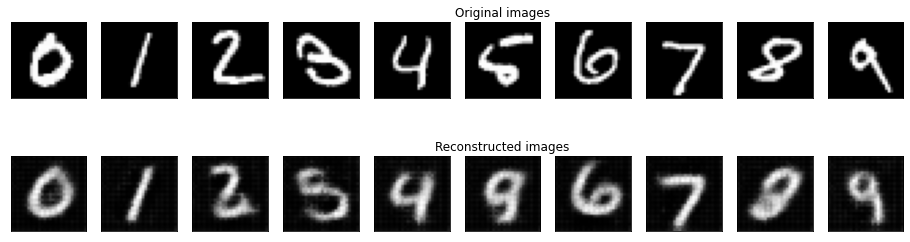


 EPOCH 10/50 	 train loss 34.29829950968424 	 val loss 34.16142462158203


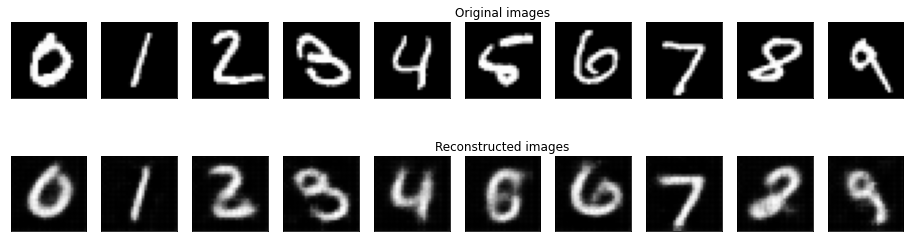


 EPOCH 15/50 	 train loss 33.464117167154946 	 val loss 33.54428371582031


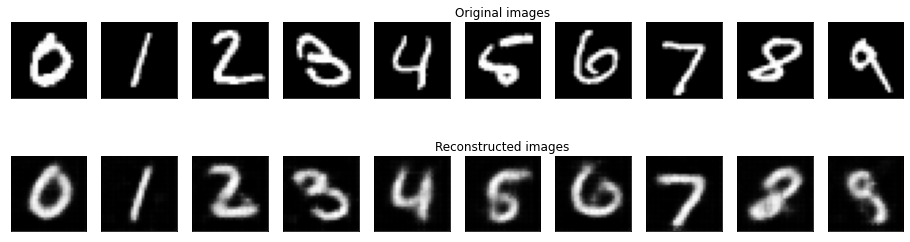


 EPOCH 20/50 	 train loss 32.987590199788414 	 val loss 33.11383173522949


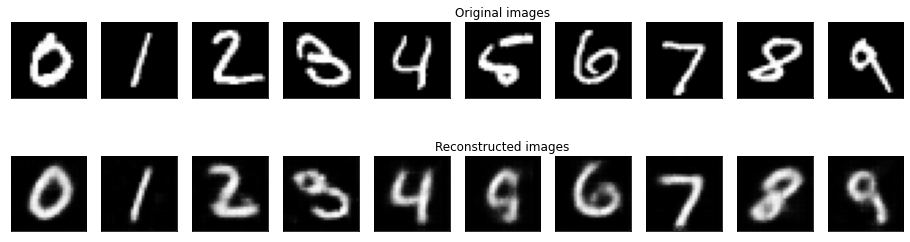


 EPOCH 25/50 	 train loss 32.66631049601237 	 val loss 32.66681854248047


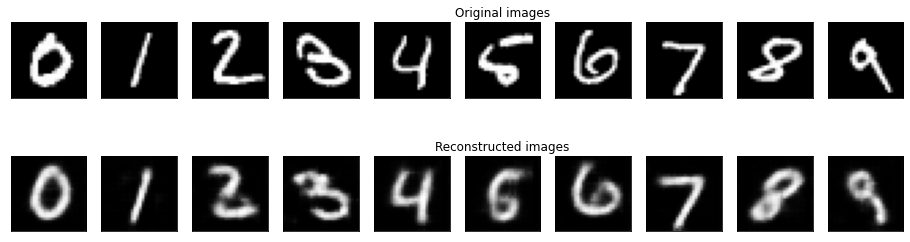


 EPOCH 30/50 	 train loss 32.40088282267253 	 val loss 32.5364554321289


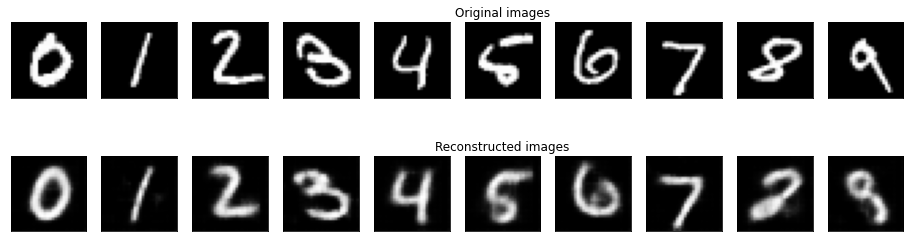


 EPOCH 35/50 	 train loss 32.23204524739583 	 val loss 32.54161227416992


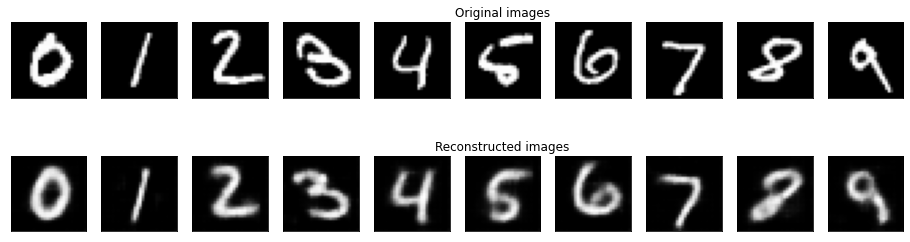


 EPOCH 40/50 	 train loss 32.049188049316406 	 val loss 32.20701637573242


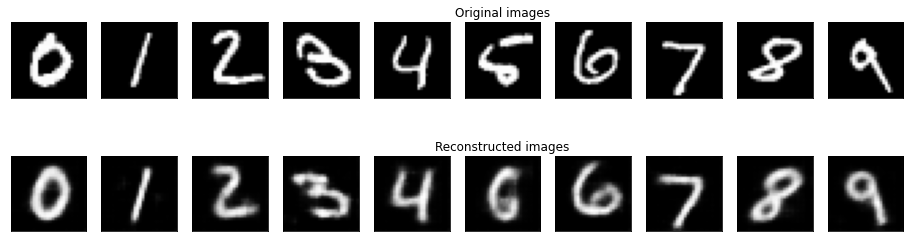


 EPOCH 45/50 	 train loss 31.911109700520832 	 val loss 32.16693717346192


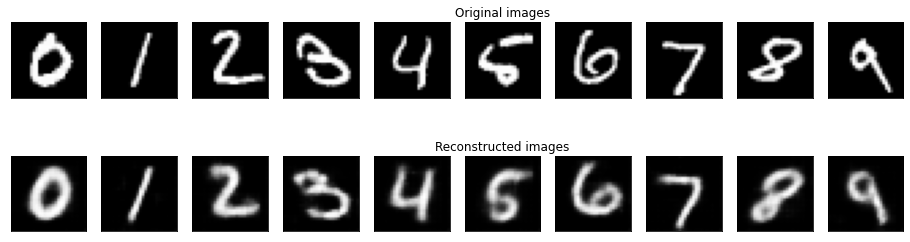


 EPOCH 50/50 	 train loss 31.799113087972007 	 val loss 31.99235739746094


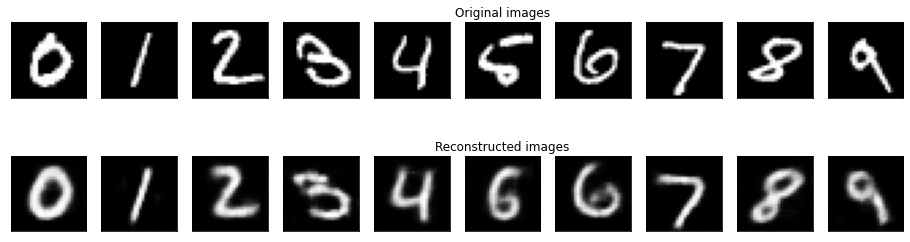

In [11]:
num_epochs = 50
diz_loss = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, test_loader)
    
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    
    if epoch == 0 or ((epoch+1) % 5 == 0):
        print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_loss} \t val loss {val_loss}')
        plot_ae_outputs(vae.encoder, vae.decoder, n=10)

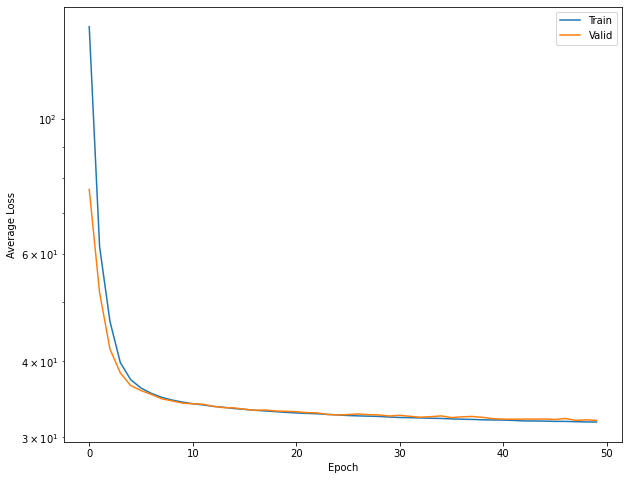

In [12]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# Generation of New Samples from the Random Latent Code

In [13]:
# A function that shows image

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

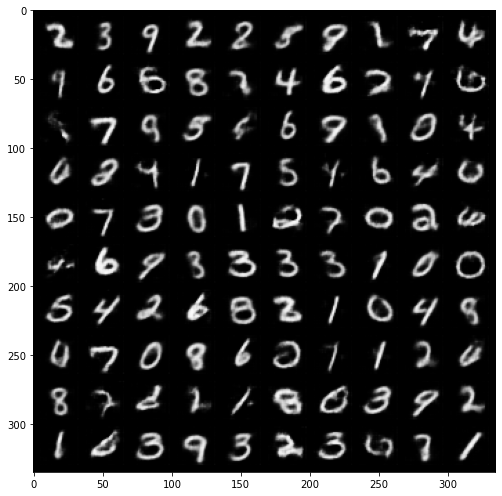

In [14]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100], 10, 5))
    plt.show()

# Visualization of Latent Space with t-SNE

In [15]:
encoded_samples = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            1.109243        -1.542952        -0.969670         0.302640   
1           -0.525418        -0.624553         1.123870         1.050052   
2            1.663987         0.407794         0.214424         1.095165   
3           -0.294649         0.161042        -0.373012        -0.887825   
4           -0.250565         0.435414        -1.057406        -0.320065   
...               ...              ...              ...              ...   
9995        -0.098533        -1.346818         0.472581         0.125387   
9996        -1.086884        -0.062342         0.690994         0.215354   
9997         1.010907         0.858920        -0.625167        -0.023921   
9998         0.481301         0.583866         0.336929        -0.716623   
9999        -0.798148         1.595501        -0.012536        -1.062921   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

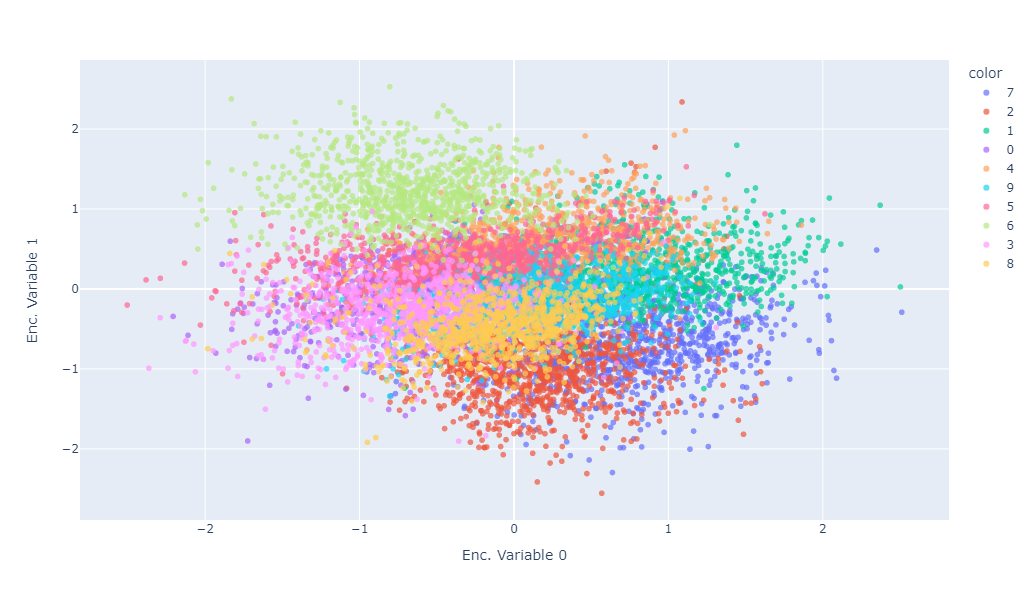

In [16]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7,
           width=800, height=600)

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



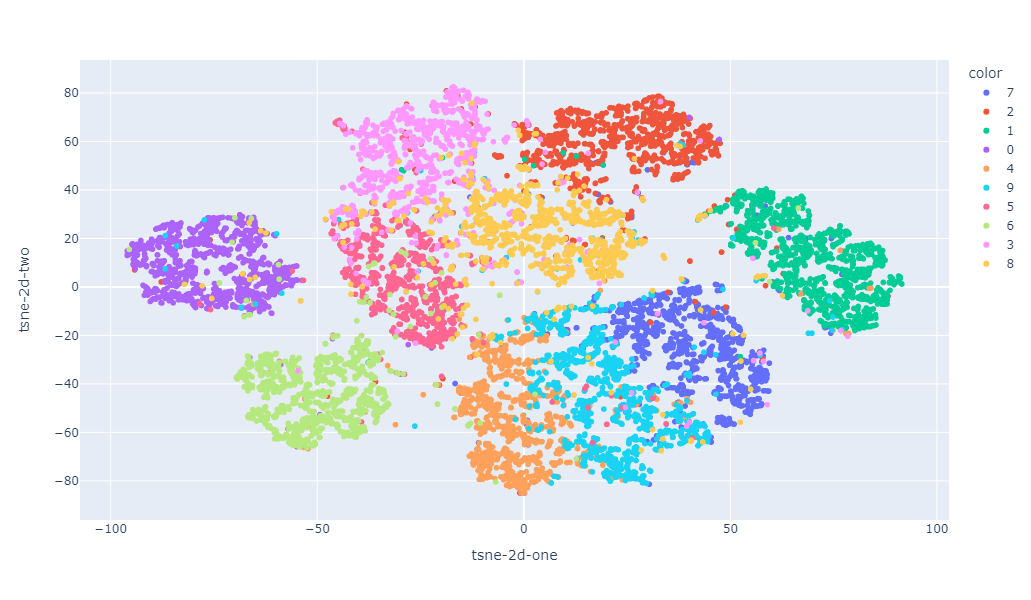

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'], axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'},
                 width=800, height=600)
fig.show()